In [ ]:
!git clone https://github.com/devaldicaliesta/dataset-organik-anorganik.git

Cloning into 'dataset-organik-anorganik'...
remote: Enumerating objects: 24760, done.
remote: Total 24760 (delta 0), reused 0 (delta 0), pack-reused 24760
Receiving objects: 100% (24760/24760), 207.36 MiB | 28.57 MiB/s, done.
Updating files: 100% (50154/50154), done.


In [ ]:
# Dependencies
import pandas as pd
import numpy as np
import logging
import tensorflow as tf
import warnings
import glob
import tqdm
import os


from tqdm import tqdm
from IPython import display
import matplotlib.pyplot as plt
import seaborn as sns
from seaborn import heatmap

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

from skimage.io import imread, imshow
from skimage.transform import resize
from keras.preprocessing import image

from keras.models import Sequential, load_model
from keras.layers import Conv2D, Lambda, MaxPooling2D, Dense, Dropout, Flatten # convolution layers & core layers

from tensorflow.keras.layers import BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from keras.utils.np_utils import to_categorical

from tensorflow import keras
from tensorflow.keras import Model
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications import MobileNetV3Large
from tensorflow.keras.layers import Dropout, GlobalAveragePooling2D, BatchNormalization, Dense
from tensorflow.keras import activations, regularizers, initializers
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, History

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import random
import math
import os
import cv2 as cv
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures, StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split

In [ ]:
import os

DIR = "/content/dataset-organik-anorganik/DATASET"

# Fungsi untuk menghitung jumlah file dalam suatu direktori
def count_files(directory):
    count = 0
    for _, _, files in os.walk(directory):
        count += len(files)
    return count

# Fungsi untuk mengecek jumlah file dalam setiap folder
def count_files_in_folders(directory):
    folder_count = {}
    for root, dirs, _ in os.walk(directory):
        for dir_name in dirs:
            folder_path = os.path.join(root, dir_name)
            file_count = count_files(folder_path)
            folder_count[folder_path] = file_count
    return folder_count

# Memanggil fungsi count_files_in_folders untuk mendapatkan jumlah file dalam setiap folder
folder_counts = count_files_in_folders(DIR)

# Memanggil fungsi count_files untuk menghitung jumlah file
file_count = count_files(DIR)

# Menampilkan hasil
print("Jumlah file dalam direktori", DIR, "adalah:", file_count)
print('\n')

# Menampilkan hasil
for folder, count in folder_counts.items():
    print("Jumlah file dalam folder", folder, "adalah:", count)

Jumlah file dalam direktori /content/dataset-organik-anorganik/DATASET adalah: 25077


Jumlah file dalam folder /content/dataset-organik-anorganik/DATASET/TRAIN adalah: 22564
Jumlah file dalam folder /content/dataset-organik-anorganik/DATASET/TEST adalah: 2513
Jumlah file dalam folder /content/dataset-organik-anorganik/DATASET/TRAIN/R adalah: 9999
Jumlah file dalam folder /content/dataset-organik-anorganik/DATASET/TRAIN/O adalah: 12565
Jumlah file dalam folder /content/dataset-organik-anorganik/DATASET/TEST/R adalah: 1112
Jumlah file dalam folder /content/dataset-organik-anorganik/DATASET/TEST/O adalah: 1401


In [ ]:
base_dir="/content/dataset-organik-anorganik/DATASET"
train_dir=os.path.join(base_dir,"TRAIN")
test_dir=os.path.join(base_dir,"TEST")

In [ ]:
# Os path join (train)

train_o = glob.glob(os.path.join(train_dir, 'O', '*.jpg'))
train_r = glob.glob(os.path.join(train_dir, 'R', '*.jpg'))

a = len(train_o)
b = len(train_r)

print("Number of training samples: {}".format(a+b))

Number of training samples: 22564


In [ ]:
# Os path join (test)

test_o = glob.glob(os.path.join(test_dir, 'O', '*.jpg'))
test_r = glob.glob(os.path.join(test_dir, 'R', '*.jpg'))

a = len(test_o)
b = len(test_r)


print("Number of test samples: {}".format(a+b))

Number of test samples: 2513


In [ ]:
train_dataset = tf.keras.preprocessing.image_dataset_from_directory(train_dir,validation_split = 0.2, subset = "training", seed=42,
                                                                    batch_size=128,
                                                                smart_resize=True,image_size=(256, 256))

val_dataset = tf.keras.preprocessing.image_dataset_from_directory(train_dir,validation_split = 0.2, subset = "validation", seed=42,
                                                                  batch_size=128,
                                                                smart_resize=True,image_size=(256, 256))

test_dataset = tf.keras.preprocessing.image_dataset_from_directory(test_dir, batch_size=128,
                                                                smart_resize=True,image_size=(256, 256))

Found 22564 files belonging to 2 classes.
Using 18052 files for training.
Found 22564 files belonging to 2 classes.
Using 4512 files for validation.
Found 2513 files belonging to 2 classes.


In [ ]:
classes = train_dataset.class_names
numClasses = len(train_dataset.class_names)

AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
val_dataset = val_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

print(f"There are {numClasses} classes.")
print(f"The class names are: {classes}")

There are 2 classes.
The class names are: ['O', 'R']


In [ ]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.Rescaling(1./255),
    tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
    tf.keras.layers.experimental.preprocessing.RandomZoom(0.2),
])

In [ ]:
Inception_V3_Model = tf.keras.applications.InceptionV3(input_shape=(256, 256, 3),weights='imagenet',
                                                       include_top=False,classes=numClasses)

for layer in Inception_V3_Model.layers[:255]:
    layer.trainable = False
for layer in Inception_V3_Model.layers[255:]:
    layer.trainable = True


preprocess_input = tf.keras.applications.inception_v3.preprocess_input
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()

inputs = tf.keras.Input(shape=(256, 256, 3))
x = preprocess_input(inputs)
x = Inception_V3_Model(x)
x = data_augmentation(x)
x = global_average_layer(x)
x = tf.keras.layers.Dense(1024, activation='relu')(x)
x = tf.keras.layers.Dropout(0.5)(x)
outputs = tf.keras.layers.Dense(numClasses, activation='softmax')(x)

inception_model = Model(inputs=inputs, outputs=outputs)

87910968/87910968 [==============================] - 0s 0us/step


In [ ]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
loss = tf.keras.losses.SparseCategoricalCrossentropy()

inception_model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

callbacks = tf.keras.callbacks.EarlyStopping(patience=2,
                                             monitor= 'val_loss',
                                             mode= 'min')
epochs=50
history = inception_model.fit(train_dataset,epochs=epochs, callbacks=[callbacks])

Epoch 1/50
 11/142 [=>............................] - ETA: 48:47 - loss: 0.6896 - accuracy: 0.5696

In [ ]:
inception_model.summary()

In [ ]:
baseModel = tf.keras.applications.ResNet152(input_shape=(256, 256, 3), weights='imagenet',
                                           include_top=False, classes=numClasses)

for layers in baseModel.layers:
    layers.trainable=False

last_output = baseModel.layers[-1].output
x = tf.keras.layers.Dropout(0.5)(last_output)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(128)(x)
x = tf.keras.layers.ReLU()(x)
x = tf.keras.layers.Dense(numClasses, activation='softmax')(x)

resnet_model = tf.keras.Model(inputs=baseModel.input, outputs=x)

In [ ]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
loss = tf.keras.losses.SparseCategoricalCrossentropy()

resnet_model.compile(optimizer=optimizer,
                        loss=loss,
                        metrics=['accuracy'])

epochs=50
callbacks = tf.keras.callbacks.EarlyStopping(patience=2,
                                             monitor= 'val_loss',
                                             mode= 'min')

history = resnet_model.fit(train_dataset, validation_data=val_dataset,
                    epochs=epochs, callbacks=[callbacks])

Epoch 1/50
142/142 [==============================] - 217s 1s/step - loss: 0.0114 - accuracy: 0.9957 - val_loss: 0.3319 - val_accuracy: 0.9342
Epoch 2/50
142/142 [==============================] - 204s 1s/step - loss: 0.0131 - accuracy: 0.9947 - val_loss: 0.4418 - val_accuracy: 0.9273
Epoch 3/50
142/142 [==============================] - 204s 1s/step - loss: 0.0094 - accuracy: 0.9963 - val_loss: 0.3580 - val_accuracy: 0.9406


In [ ]:
# Load MobileNetV3Large model with pre-trained weights
baseModel = MobileNetV3Large(input_shape=(256, 256, 3), weights='imagenet', include_top=False, classes=numClasses)

# Freeze layers except for the last 6 layers
for layer in baseModel.layers[:-6]:
    layer.trainable = False

# Create the model head
last_output = baseModel.layers[-1].output
x = Dropout(0.45)(last_output)
x = GlobalAveragePooling2D()(x)
x = BatchNormalization()(x)
x = Dense(256, activation=activations.elu, kernel_regularizer=regularizers.l1(0.045),
          activity_regularizer=regularizers.l1(0.045), kernel_initializer=initializers.he_normal())(x)
x = Dropout(0.45)(x)
outputs = Dense(numClasses, activation='softmax')(x)

# Create the final model
mobilenet_model = Model(inputs=baseModel.input, outputs=outputs)

In [ ]:
mobilenet_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.00125),
               loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
               metrics=['accuracy'])

epochs = 50
callbacks = tf.keras.callbacks.EarlyStopping(patience=2,
                                             monitor= 'val_loss',
                                             mode= 'min')

history = mobilenet_model.fit(train_dataset, validation_data=val_dataset, epochs=epochs, callbacks=[callbacks])

Epoch 1/50
142/142 [==============================] - 46s 279ms/step - loss: 74.7039 - accuracy: 0.8810 - val_loss: 2.7501 - val_accuracy: 0.8706
Epoch 2/50
142/142 [==============================] - 42s 290ms/step - loss: 2.4984 - accuracy: 0.9158 - val_loss: 2.8193 - val_accuracy: 0.9078
Epoch 3/50
142/142 [==============================] - 39s 271ms/step - loss: 2.4267 - accuracy: 0.9278 - val_loss: 2.6836 - val_accuracy: 0.9342
Epoch 4/50
142/142 [==============================] - 39s 264ms/step - loss: 2.3631 - accuracy: 0.9345 - val_loss: 2.4697 - val_accuracy: 0.9397
Epoch 5/50
142/142 [==============================] - 42s 288ms/step - loss: 2.3034 - accuracy: 0.9406 - val_loss: 2.8084 - val_accuracy: 0.9362
Epoch 6/50
142/142 [==============================] - 39s 269ms/step - loss: 2.3639 - accuracy: 0.9429 - val_loss: 2.3202 - val_accuracy: 0.9448
Epoch 7/50
142/142 [==============================] - 38s 262ms/step - loss: 2.2498 - accuracy: 0.9444 - val_loss: 2.3082 - val_a

In [ ]:
inception_model =  tf.keras.models.load_model('/content/inception_model(2).h5')

In [ ]:
inception_model.evaluate(test_dataset)

20/20 [==============================] - 21s 567ms/step - loss: 0.2233 - accuracy: 0.9065


[0.22325260937213898, 0.9064862728118896]

In [ ]:
resnet_model.evaluate(test_dataset)

20/20 [==============================] - 23s 1s/step - loss: 0.5525 - accuracy: 0.8874


[0.5524502992630005, 0.8873856067657471]

In [ ]:
mobilenet_model.evaluate(test_dataset)

20/20 [==============================] - 5s 194ms/step - loss: 2.4777 - accuracy: 0.9327


[2.4776699542999268, 0.9327496886253357]

In [ ]:
resnet_model.save('./resnet_model(2).h5')

In [ ]:
mobilenet_model.save('./mobilenet_model(2).h5')

3/3 [==============================] - 1s 42ms/step


<Figure size 1000x1000 with 0 Axes>

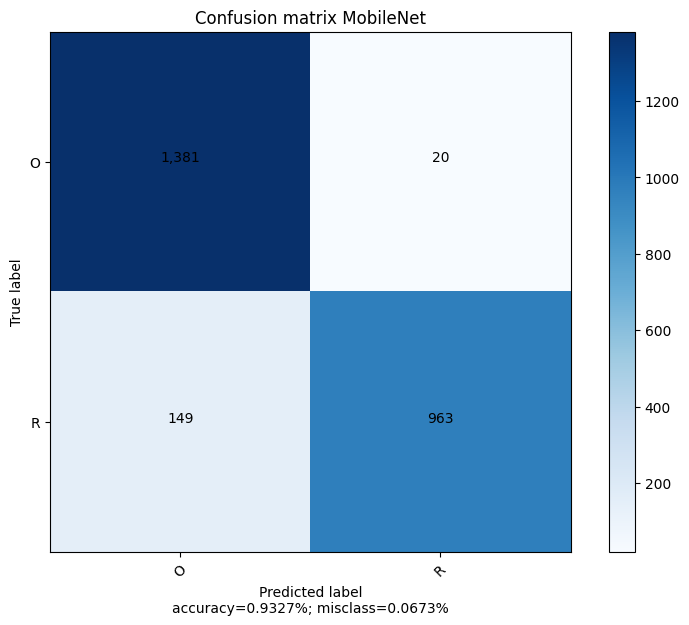

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def plot_confusion_matrix(cm, target_names, cmap='Blues'):
    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title('Confusion matrix MobileNet')
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel(f'Predicted label\naccuracy={accuracy:.4f}%; misclass={misclass:.4f}%')
    plt.show()

plt.figure(figsize=(10, 10))
true = []
predictions = []

# Loop through the test dataset
for images, labels in test_dataset:
    preds = mobilenet_model.predict(images)  # Assuming you have a model named 'model'
    true.extend(labels.numpy())
    predictions.extend(np.argmax(preds, axis=1))

plot_confusion_matrix(tf.math.confusion_matrix(true, predictions), target_names=classes)

In [ ]:
tp = 1381
fp = 20
fn = 149
tn = 963


# Calculate precision
precision = tp / (tp + fp)

# Calculate recall
recall = tp / (tp + fn)

# Calculate F1 score
f1_score = 2 * (precision * recall) / (precision + recall)

print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1_score)

Precision: 0.9857244825124911
Recall: 0.9026143790849673
F1 Score: 0.9423404981235074


3/3 [==============================] - 3s 286ms/step


<Figure size 1000x1000 with 0 Axes>

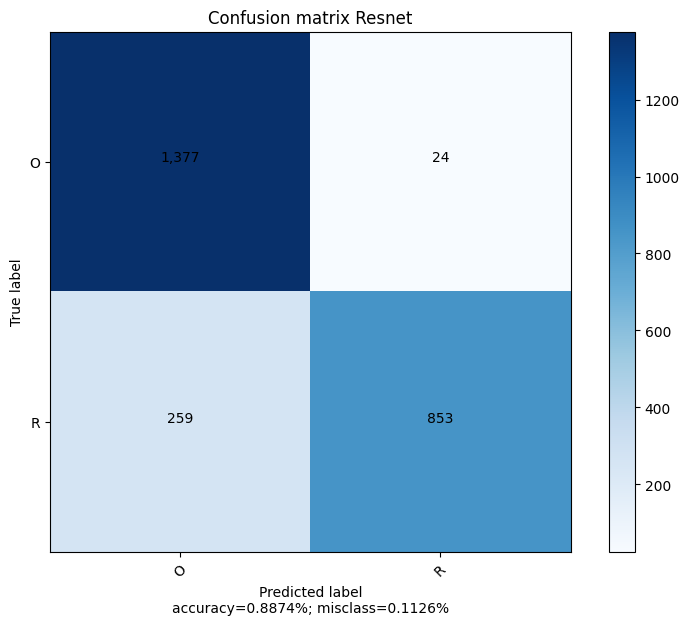

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def plot_confusion_matrix(cm, target_names, cmap='Blues'):
    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title('Confusion matrix Resnet')
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel(f'Predicted label\naccuracy={accuracy:.4f}%; misclass={misclass:.4f}%')
    plt.show()

plt.figure(figsize=(10, 10))
true = []
predictions = []

# Loop through the test dataset
for images, labels in test_dataset:
    preds = resnet_model.predict(images)  # Assuming you have a model named 'model'
    true.extend(labels.numpy())
    predictions.extend(np.argmax(preds, axis=1))

plot_confusion_matrix(tf.math.confusion_matrix(true, predictions), target_names=classes)

In [ ]:
tp = 1377
fp = 24
fn = 259
tn = 853


# Calculate precision
precision = tp / (tp + fp)

# Calculate recall
recall = tp / (tp + fn)

# Calculate F1 score
f1_score = 2 * (precision * recall) / (precision + recall)

print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1_score)

Precision: 0.9828693790149893
Recall: 0.8416870415647921
F1 Score: 0.9068159367797167


3/3 [==============================] - 3s 866ms/step


<Figure size 1000x1000 with 0 Axes>

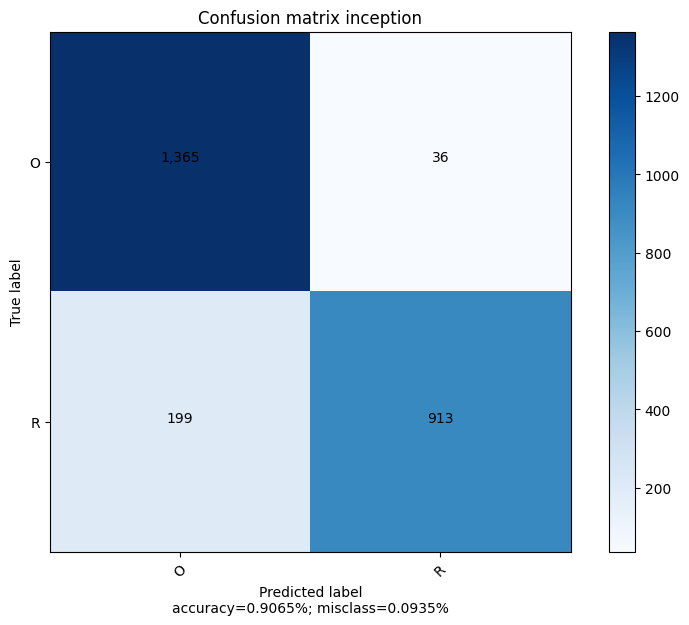

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def plot_confusion_matrix(cm, target_names, cmap='Blues'):
    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title('Confusion matrix inception')
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel(f'Predicted label\naccuracy={accuracy:.4f}%; misclass={misclass:.4f}%')
    plt.show()

plt.figure(figsize=(10, 10))
true = []
predictions = []

# Loop through the test dataset
for images, labels in test_dataset:
    preds = inception_model.predict(images)  # Assuming you have a model named 'model'
    true.extend(labels.numpy())
    predictions.extend(np.argmax(preds, axis=1))

plot_confusion_matrix(tf.math.confusion_matrix(true, predictions), target_names=classes)

In [ ]:
tp = 1365
fp = 36
fn = 199
tn = 913


# Calculate precision
precision = tp / (tp + fp)

# Calculate recall
recall = tp / (tp + fn)

# Calculate F1 score
f1_score = 2 * (precision * recall) / (precision + recall)

print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1_score)

Precision: 0.974304068522484
Recall: 0.8727621483375959
F1 Score: 0.9207419898819561
